## Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

2022-10-09 23:47:23.399531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 23:47:23.496808: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-09 23:47:23.506000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 23:47:23.506007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)

    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

## Plot field for individual poles

In [3]:
#Training data
df = pd.read_csv('data/nl_individual_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

Text(0.5, 0, '$V_3$ (arb. u.)')

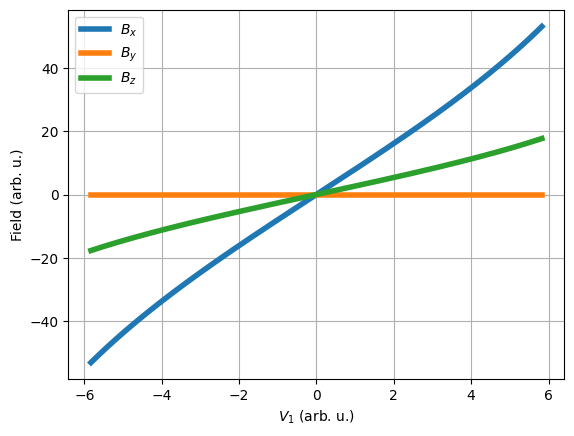

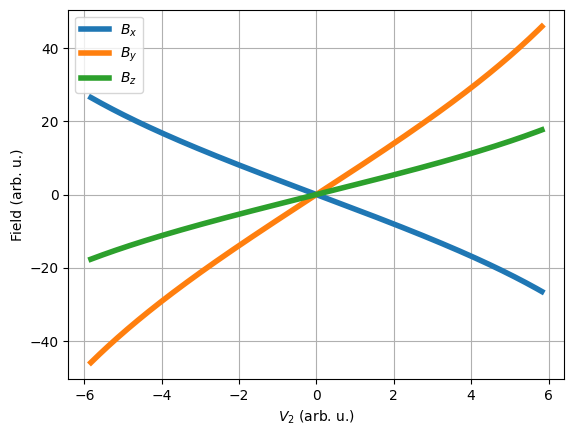

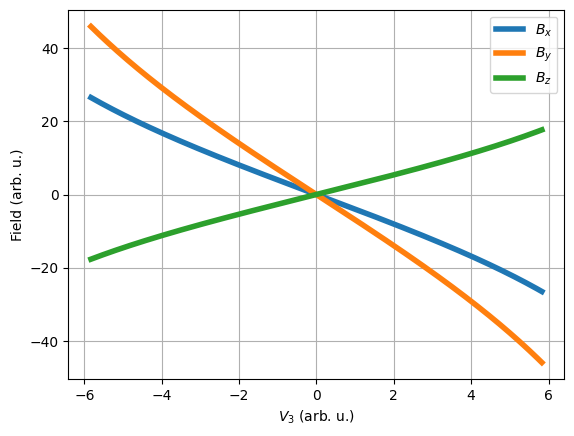

In [4]:
ax1 = B_vs_V(V1, Bx, By, Bz)
ax1.set_xlabel(r'$V_1$ (arb. u.)')

ax2 = B_vs_V(V2, Bx, By, Bz)
ax2.set_xlabel(r'$V_2$ (arb. u.)')

ax3 = B_vs_V(V3, Bx, By, Bz)
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

### Load and prepare data

In [5]:
# Training data
df_train = pd.read_csv('data/full_calibration_set.csv')
V_train = df_train[['V_1', 'V_2', 'V_3']]
B_train = df_train[['B_x', 'B_y', 'B_z']]

# Validation data
df_val = pd.read_csv('data/validation_set.csv')
V_val = df_val[['V_1', 'V_2', 'V_3']]
B_val = df_val[['B_x', 'B_y', 'B_z']]

### Create and train neural network

In [6]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(3)
])

2022-10-09 23:47:25.986722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 23:47:25.986851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 23:47:25.986885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-09 23:47:25.986906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-09 23:47:25.986926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [14]:
# Add callbacks

# Stops training if the mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=400, monitor='val_mae',restore_best_weights=True)
# Adjust learning rate is performance is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=200)
# Saves the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="models.hdf5",save_best_only=True, monitor='val_mae')

In [22]:

# Train model
history = model.fit(B_train, V_train, epochs=2000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb,learning_rate_cb ]);

Epoch 1/2000
438/438 [==============================] - 0s 765us/step - loss: 0.0014 - mae: 0.0149 - val_loss: 4.9463e-04 - val_mae: 0.0100 - lr: 0.0010
Epoch 2/2000
438/438 [==============================] - 0s 633us/step - loss: 0.0030 - mae: 0.0203 - val_loss: 0.0117 - val_mae: 0.0845 - lr: 0.0010
Epoch 3/2000
438/438 [==============================] - 0s 678us/step - loss: 7.0396e-04 - mae: 0.0121 - val_loss: 3.7143e-04 - val_mae: 0.0041 - lr: 0.0010
Epoch 4/2000
438/438 [==============================] - 0s 544us/step - loss: 1.2896e-05 - mae: 0.0021 - val_loss: 3.9800e-04 - val_mae: 0.0061 - lr: 0.0010
Epoch 5/2000
438/438 [==============================] - 0s 650us/step - loss: 0.0016 - mae: 0.0204 - val_loss: 6.1463e-04 - val_mae: 0.0144 - lr: 0.0010
Epoch 6/2000
438/438 [==============================] - 0s 602us/step - loss: 8.9399e-05 - mae: 0.0060 - val_loss: 3.8243e-04 - val_mae: 0.0064 - lr: 0.0010
Epoch 7/2000
438/438 [==============================] - 0s 600us/step - lo

(0.0, 0.5)

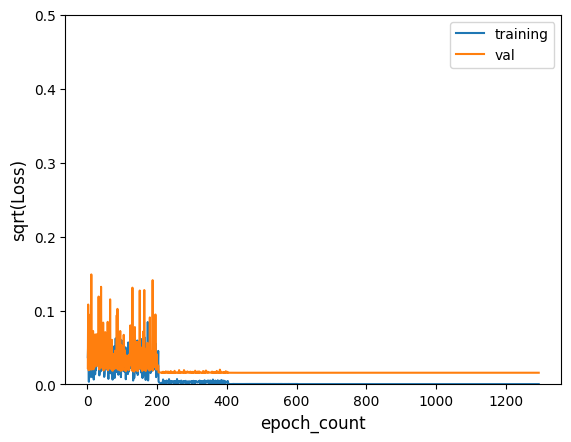

In [23]:
# Plot training process

h = history.history

training_loss = np.array(h["loss"])
test_loss = np.array(h["val_loss"])
epoch_count = np.arange(len(training_loss)) + 1

fig, ax = plt.subplots()
ax.plot(epoch_count, np.sqrt(training_loss), label='training')
ax.plot(epoch_count, np.sqrt(test_loss), label='val')
ax.set_xlabel(r'epoch_count', fontsize=12)
ax.set_ylabel(r'sqrt(Loss)', fontsize=12)
ax.legend(loc=0)
ax.set_ylim(0, 0.5)

## Test

In [24]:
# Test field
# Rotation angle
theta = np.linspace(0, 4*np.pi, 151)
B_test = []

for th in theta:
    B_test.append(1 * np.array([np.sin(th), 0, np.cos(th)]))

B_test = np.array(B_test)

In [25]:
V_test = model.predict(B_test)

nf = 15
V_test = np.tanh(V_test/nf)*10

5/5 [==============================] - 0s 976us/step


In [26]:
M_ = np.loadtxt('data/lin_cal_mat.csv')
M = np.linalg.inv(M_)
B_predict = []
for V in V_test:
    B_predict.append(np.dot(M, V))

B_predict = np.array(B_predict)

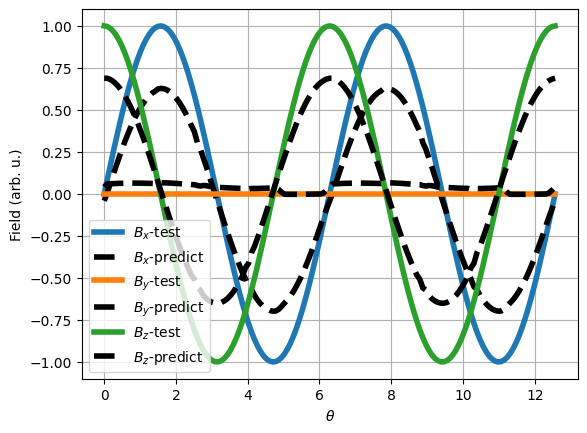

In [20]:
# Plot
fig, ax = plt.subplots()
ax.plot(theta, B_test[:,0], label=r'$B_x$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,0], label=r'$B_x$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,1], label=r'$B_y$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,1], label=r'$B_y$-predict', linewidth=4.0, color='black', ls='--')

ax.plot(theta, B_test[:,2], label=r'$B_z$-test', linewidth=4.0)
ax.plot(theta, B_predict[:,2], label=r'$B_z$-predict', linewidth=4.0, color='black', ls='--')

ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Field (arb. u.)' )
#ax.set_xlim(0,1)
ax.legend(loc=0)
ax.grid()

In [21]:
# Save model
model.save('data/model.h5')